In [14]:
%matplotlib notebook
# starter code
import random
import numpy as np
import networkx as nx

from matplotlib import pyplot as plt
from tqdm import tqdm

from graph_tool.all import load_graph, shortest_distance, GraphView, pbfs_search, BFSVisitor, Graph, min_spanning_tree, label_components
from networkx.drawing.nx_agraph import graphviz_layout

from cascade import gen_nontrivial_cascade
from utils import get_rank_index, extract_edges_from_pred, init_visitor
from ic import get_infection_time


# seed = 123456
# random.seed(seed)
# np.random.seed(seed)

gtype = 'grid'
g = load_graph('data/{}/2-6/graph.gt'.format(gtype))
gnx = nx.read_graphml('data/{}/2-6/graph.graphml'.format(gtype))
gnx = nx.relabel_nodes(gnx, {i: int(i) for i in gnx.nodes_iter()})
N1, N2 = 100, 100
p, q = 0.5, 0.5

pos = graphviz_layout(gnx, root=0)


from utils import earliest_obs_node
from tqdm import tqdm
from feasibility import is_order_respected, is_feasible
from core import find_tree_by_closure



In [5]:
def infer_infection_time_from_tree(t, source):
    t = GraphView(t)
    b = t.new_vertex_property('bool')
    b.a = True
    t.set_vertex_filter(b)
    times = get_infection_time(t, source=source)
    return times

def extract_nodes(tree):
    return set(map(int, tree.vertices()))


def num_order_violations(tree, root, obs_nodes, infection_times):
    tree = GraphView(tree)
    obs_set = set(obs_nodes)
    vfilt = tree.new_vertex_property('bool')
    vfilt.a = True
    tree.set_vertex_filter(vfilt)

    leaves = [o for o in obs_nodes if tree.vertex(o).out_degree() == 0]
    vis = init_visitor(tree, root)
    pbfs_search(tree, root, terminals=leaves, visitor=vis, count_threshold=-1)
    num_vio = 0
    for l in leaves:
        edges = extract_edges_from_pred(tree, root, l, vis.pred)
        edges = edges[::-1]
        path = list(edges[0]) + [u for _, u in edges[1:]]
        useful_nodes_on_path = [v for v in path if v in obs_set]

        for i in range(len(useful_nodes_on_path)-1):
            u, v = useful_nodes_on_path[i: i+2]
            if infection_times[u] > infection_times[v]:
                num_vio += 1
    return num_vio

def set_title(ax, name, tree):
    n_vio = num_order_violations(tree, root, obs_nodes, infection_times)
    title = "{}\n{} edges {} violations".format(name, tree.num_edges(), n_vio)
    ax.set_title(title)



In [15]:
infection_times, source, obs_nodes, true_tree = gen_nontrivial_cascade(g, p, q, model='si', return_tree=True,
                                                                       source_includable=True)

if source not in obs_nodes:
    obs_nodes = list(obs_nodes) + [source]
root = source

closure_tree = find_tree_by_closure(
    g, root, infection_times, obs_nodes,
    strictly_smaller=False,
    debug=False,
    verbose=False,
    return_closure=False
)

<IPython.core.display.Javascript object>


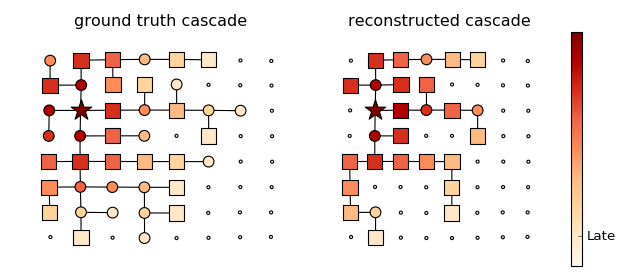

In [18]:
from plot_utils import plot_snapshot, add_colorbar
from utils import extract_edges

with_label = False
max_node_size = 750
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))
for a in ax:
    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)
    a.axis('off')
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=with_label,
              max_node_size=max_node_size,
              ax=ax[0],
              edges=extract_edges(true_tree))
ax[0].set_title('ground truth cascade')
plot_snapshot(gnx, pos, infer_infection_time_from_tree(closure_tree, root), queried_nodes=obs_nodes, source_node=source, with_labels=with_label,
             ax=ax[1], arrows=True, 
              max_node_size=max_node_size,
             edges=extract_edges(closure_tree))
# set_title(ax[1], 'closure', closure_tree)
ax[1].set_title('reconstructed cascade')

import matplotlib as mpl
tick_locator = mpl.ticker.MaxNLocator(nbins=2)


cmap='OrRd'
eps = np.maximum(0.0000000001, np.min(infection_times)/1000.)
vmin = np.min(infection_times) - eps
vmax = np.max(infection_times)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
scm = mpl.cm.ScalarMappable(norm, cmap)
scm.set_array(infection_times)
cbar = plt.colorbar(scm)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.ax.set_yticklabels(['Late', '', 'Early'])
plt.tight_layout()

<IPython.core.display.Javascript object>


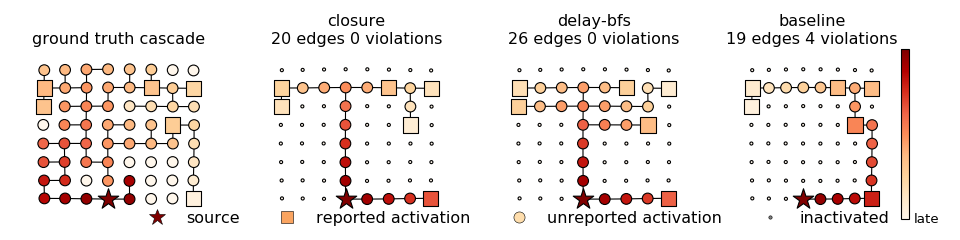

In [123]:
from plot_utils import plot_snapshot, add_colorbar
from utils import extract_edges

with_label = False
max_node_size = 750
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
for a in ax:
    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)
    a.axis('off')
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=with_label,
              max_node_size=max_node_size,
              ax=ax[0],
              edges=extract_edges(true_tree))
ax[0].set_title('ground truth cascade')
plot_snapshot(gnx, pos, infer_infection_time_from_tree(closure_tree, root), queried_nodes=obs_nodes, source_node=source, with_labels=with_label,
             ax=ax[1], arrows=True, 
              max_node_size=max_node_size,
             edges=extract_edges(closure_tree))
set_title(ax[1], 'closure', closure_tree)

plot_snapshot(gnx, pos, infer_infection_time_from_tree(tbfs_tree, root), queried_nodes=obs_nodes, source_node=source, with_labels=with_label,
              ax=ax[2], arrows=True,
              max_node_size=max_node_size,
              edges=extract_edges(tbfs_tree))
set_title(ax[2], 'delay-bfs', tbfs_tree)

plot_snapshot(gnx, pos, infer_infection_time_from_tree(st_tree, root), queried_nodes=obs_nodes, source_node=source, with_labels=with_label,
              ax=ax[3], arrows=True,
              max_node_size=max_node_size,
              edges=extract_edges(st_tree_dir))
set_title(ax[3], 'baseline', st_tree_dir)

import matplotlib as mpl
tick_locator = mpl.ticker.MaxNLocator(nbins=2)


cmap='OrRd'
eps = np.maximum(0.0000000001, np.min(infection_times)/1000.)
vmin = np.min(infection_times) - eps
vmax = np.max(infection_times)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
scm = mpl.cm.ScalarMappable(norm, cmap)
scm.set_array(infection_times)
cbar = plt.colorbar(scm)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.ax.set_yticklabels(['late', '', 'early'])

plt.tight_layout()


In [124]:
from matplotlib.lines import Line2D


line1 = Line2D(range(1), range(1), color="white", marker='*', markerfacecolor="maroon", markersize=15)
line2 = Line2D(range(1), range(1), color="white", marker='s',markerfacecolor="sandybrown", markersize=10)
line3 = Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="navajowhite", markersize=10)
line4 = Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="gray", markersize=3)
ax[2].legend((line1,line2,line3,line4),('source', 'reported activation', 'unreported activation', 'inactivated'),
         numpoints=1,
         ncol=4, loc='lower center',         
         frameon=False,
         bbox_to_anchor=(0.1, -0.125))


In [20]:
def get_figure_axes():
    fig = plt.figure(figsize=(s, s-0.5))
    ax = fig.add_subplot(111)    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    return fig, ax
    

<IPython.core.display.Javascript object>


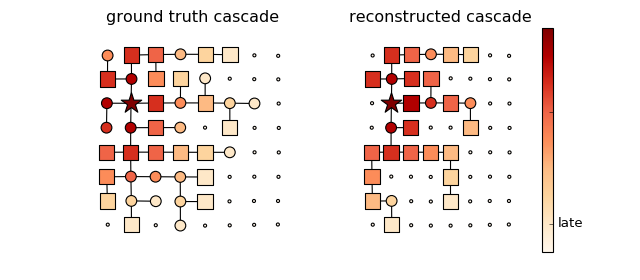

In [34]:
import matplotlib as mpl
from plot_utils import plot_snapshot, add_colorbar
from utils import extract_edges

with_label = False
max_node_size = 750
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))
for a in ax:
    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)
    a.axis('off')
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=with_label,
              max_node_size=max_node_size,
              ax=ax[0],
              edges=extract_edges(true_tree))
ax[0].set_title('ground truth cascade')
plot_snapshot(gnx, pos, infer_infection_time_from_tree(closure_tree, root), queried_nodes=obs_nodes, source_node=source, with_labels=with_label,
             ax=ax[1], arrows=True, 
              max_node_size=max_node_size,
             edges=extract_edges(closure_tree))
# set_title(ax[1], 'closure', closure_tree)
ax[1].set_title('reconstructed cascade')



cmap='OrRd'
eps = np.maximum(0.0000000001, np.min(infection_times)/1000.)
vmin = np.min(infection_times) - eps
vmax = np.max(infection_times)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
scm = mpl.cm.ScalarMappable(norm, cmap)
scm.set_array(infection_times)

cbar = plt.colorbar(scm)
tick_locator = mpl.ticker.MaxNLocator(nbins=3)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.ax.set_yticklabels(['late', '','early'])



<IPython.core.display.Javascript object>


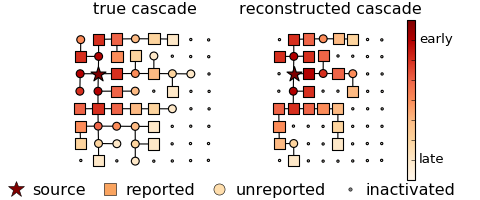

In [100]:
from plot_utils import plot_snapshot, add_colorbar
from utils import extract_edges

with_label = False
max_node_size = 400
fig, axes = plt.subplots(1, 2, figsize=(6, 2.5))
for a in axes:
    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)
    a.axis('off')
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=with_label,
              max_node_size=max_node_size,
              ax=axes[0],
              edges=extract_edges(true_tree))
axes[0].set_title('true cascade')
plot_snapshot(gnx, pos, infer_infection_time_from_tree(closure_tree, root), queried_nodes=obs_nodes, source_node=source, with_labels=with_label,
             ax=axes[1], arrows=True, 
              max_node_size=max_node_size,
             edges=extract_edges(closure_tree))
axes[1].set_title('reconstructed cascade')
# set_title(axes[1], 'closure', closure_tree)


import matplotlib as mpl



cmap='OrRd'
eps = np.maximum(0.0000000001, np.min(infection_times)/1000.)
vmin = np.min(infection_times) - eps
vmax = np.max(infection_times)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
scm = mpl.cm.ScalarMappable(norm, cmap)
scm.set_array(infection_times)

cbar = plt.colorbar(scm)
# tick_locator = mpl.ticker.MaxNLocator(nbins=3)
# cbar.locator = tick_locator
# cbar.update_ticks()
cbar.ax.set_yticklabels(['', 'late', '', '', '', '', '', 'early'])

from matplotlib.lines import Line2D

# fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
# ax = axes[0]

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

line1 = Line2D(range(1), range(1), color="white", marker='*', markerfacecolor="maroon", markersize=15)
line2 = Line2D(range(1), range(1), color="white", marker='s',markerfacecolor="sandybrown", markersize=10)
line3 = Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="navajowhite", markersize=10)
line4 = Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="gray", markersize=3)
ax.legend((line1,line2,line3,line4),('source', 'reported', 'unreported', 'inactivated'),
         numpoints=1,
         ncol=4, loc='lower left',
         bbox_to_anchor=(-0.2, -0.2),
         columnspacing=0.5,
         handletextpad=0,
         frameon=False)
fig.show()
fig.savefig(dirname + 'legend.pdf')

In [101]:
fig.savefig('figs/motivation/illustration.pdf')